## Preprocess and Explore Data

In [18]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [87]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-12-31'

historical_data = {}
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Check if data is empty
    if data.empty:
        print(f"No data fetched for {ticker}.")
    else:
        historical_data[ticker] = data['Adj Close']  # Store only adjusted close prices

# Print historical data to check structure
print("\nHistorical Data:")
for ticker, series in historical_data.items():
    print(f"{ticker} data:")
    print(series.head())  # Print first few rows of each series

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Historical Data:
TSLA data:
Ticker                          TSLA
Date                                
2015-01-02 00:00:00+00:00  14.620667
2015-01-05 00:00:00+00:00  14.006000
2015-01-06 00:00:00+00:00  14.085333
2015-01-07 00:00:00+00:00  14.063333
2015-01-08 00:00:00+00:00  14.041333
BND data:
Ticker                           BND
Date                                
2015-01-02 00:00:00+00:00  63.358757
2015-01-05 00:00:00+00:00  63.542736
2015-01-06 00:00:00+00:00  63.726677
2015-01-07 00:00:00+00:00  63.765045
2015-01-08 00:00:00+00:00  63.665405
SPY data:
Ticker                            SPY
Date                                 
2015-01-02 00:00:00+00:00  173.173752
2015-01-05 00:00:00+00:00  170.046265
2015-01-06 00:00:00+00:00  168.444672
2015-01-07 00:00:00+00:00  170.543640
2015-01-08 00:00:00+00:00  173.569977


In [88]:
try:
    combined_data = pd.concat(historical_data.values(), axis=1)
    combined_data.columns = historical_data.keys()  # Set the column names
    print("\nCombined Data:")
    print(combined_data.head())
except ValueError as e:
    print(f"Error creating DataFrame with concat: {e}")


Combined Data:
                                TSLA        BND         SPY
Date                                                       
2015-01-02 00:00:00+00:00  14.620667  63.358757  173.173752
2015-01-05 00:00:00+00:00  14.006000  63.542736  170.046265
2015-01-06 00:00:00+00:00  14.085333  63.726677  168.444672
2015-01-07 00:00:00+00:00  14.063333  63.765045  170.543640
2015-01-08 00:00:00+00:00  14.041333  63.665405  173.569977


In [89]:
print(combined_data.describe())

              TSLA          BND          SPY
count  2481.000000  2481.000000  2481.000000
mean    111.888597    70.096891   311.018494
std     110.298986     4.885138   112.023547
min       9.578000    62.637581   157.328568
25%      17.086000    66.327988   214.852249
50%      25.166000    68.914566   276.051147
75%     217.733337    73.801575   402.683716
max     409.970001    79.812927   597.739990


In [92]:
print("\nMissing values:")
print(combined_data.isnull().sum())


Missing values:
TSLA    0
BND     0
SPY     0
dtype: int64


## Exploratory Data Analysis

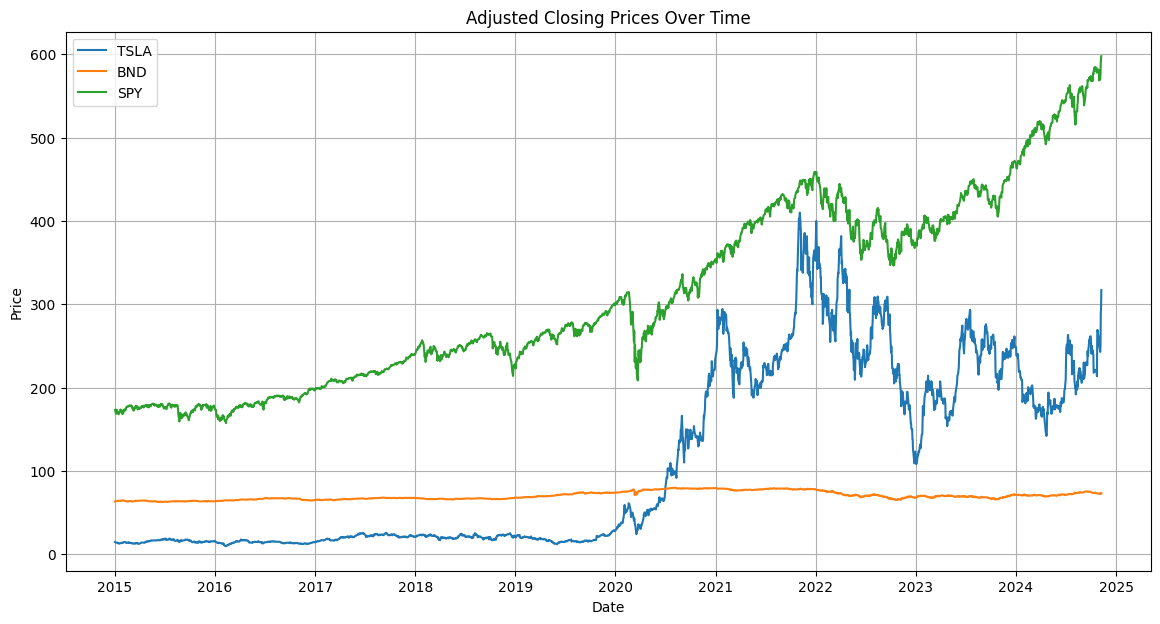

In [94]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(combined_data[ticker], label=ticker)
plt.title('Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

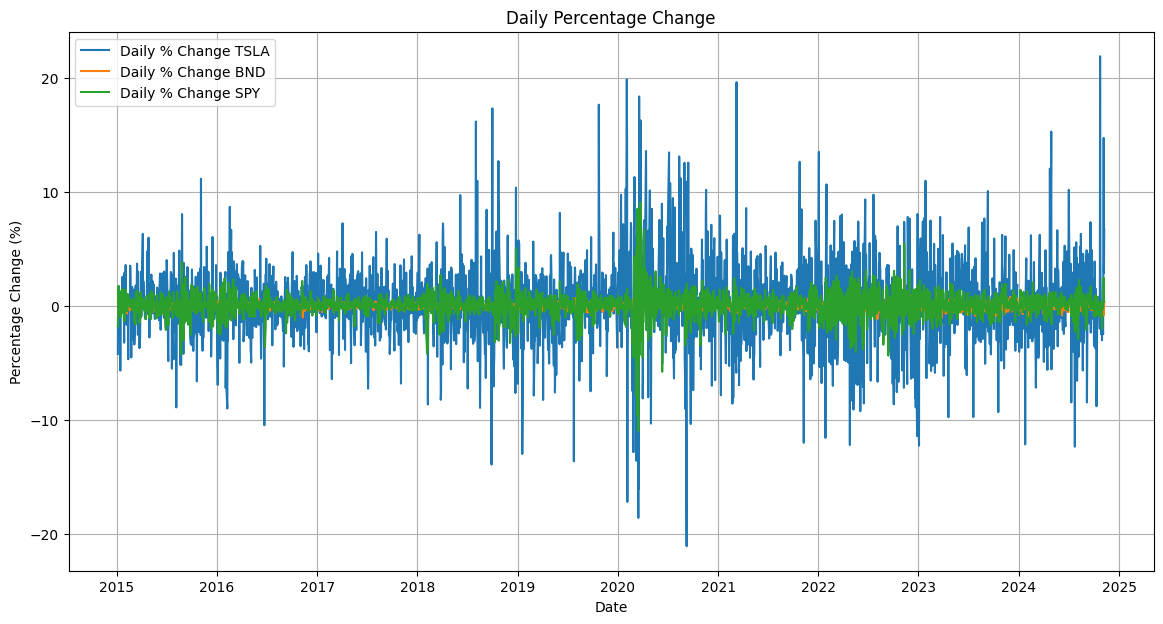

In [95]:
# Calculate daily percentage change
daily_returns = combined_data.pct_change() * 100

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(daily_returns[ticker], label=f'Daily % Change {ticker}')
plt.title('Daily Percentage Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid()
plt.show()

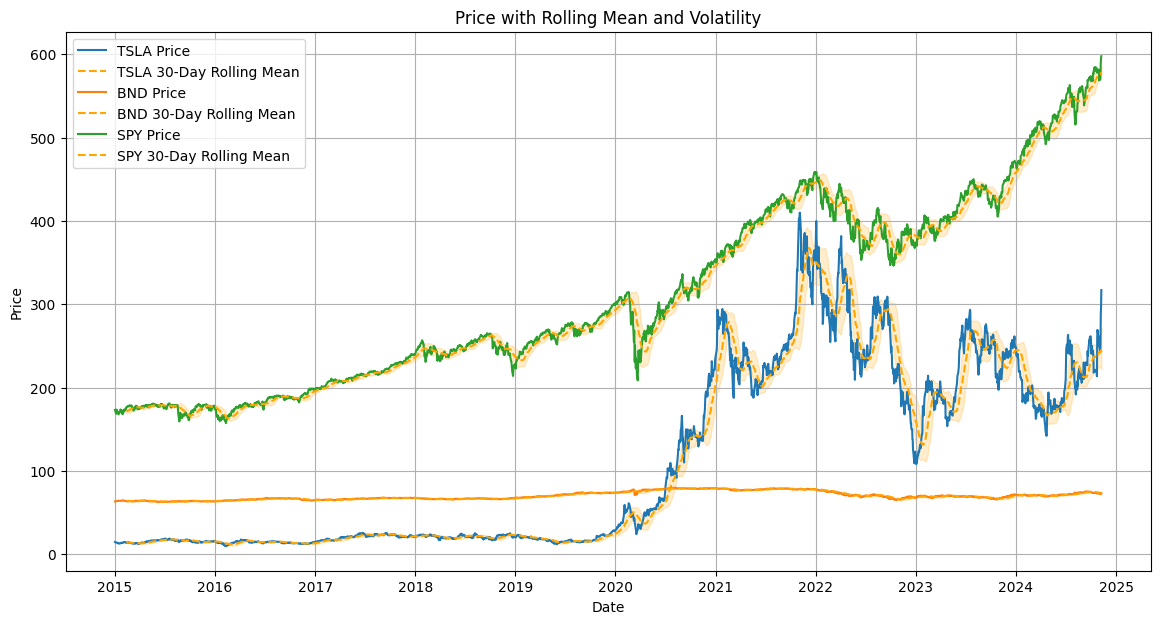

In [96]:
rolling_mean = combined_data.rolling(window=30).mean()
rolling_std = combined_data.rolling(window=30).std()

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(combined_data[ticker], label=f'{ticker} Price')
    plt.plot(rolling_mean[ticker], label=f'{ticker} 30-Day Rolling Mean', linestyle='--', color='orange')
    plt.fill_between(rolling_std.index, 
                     rolling_mean[ticker] - rolling_std[ticker], 
                     rolling_mean[ticker] + rolling_std[ticker], 
                     alpha=0.2, color='orange')
plt.title('Price with Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [97]:
threshold = 3  # Standard deviations
outliers = daily_returns[(daily_returns - daily_returns.mean()).abs() > threshold * daily_returns.std()]

print("\nOutliers in Daily Returns:")
print(outliers.dropna())


Outliers in Daily Returns:
                                TSLA       BND        SPY
Date                                                     
2020-03-12 00:00:00+00:00 -11.617242 -5.438449  -9.567727
2020-03-16 00:00:00+00:00 -18.577806  1.051111 -10.942360
2020-03-18 00:00:00+00:00 -16.034404 -2.414005  -5.063305


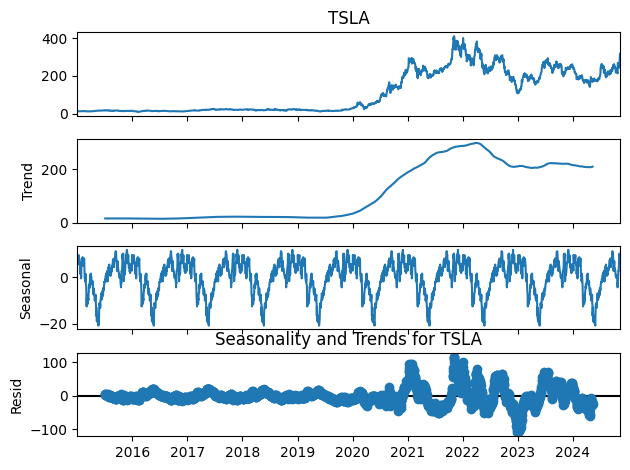

In [98]:
decomposition = seasonal_decompose(combined_data['TSLA'], model='additive', period=252)  # Approx. trading days in a year
decomposition.plot()
plt.title('Seasonality and Trends for TSLA')
plt.show()

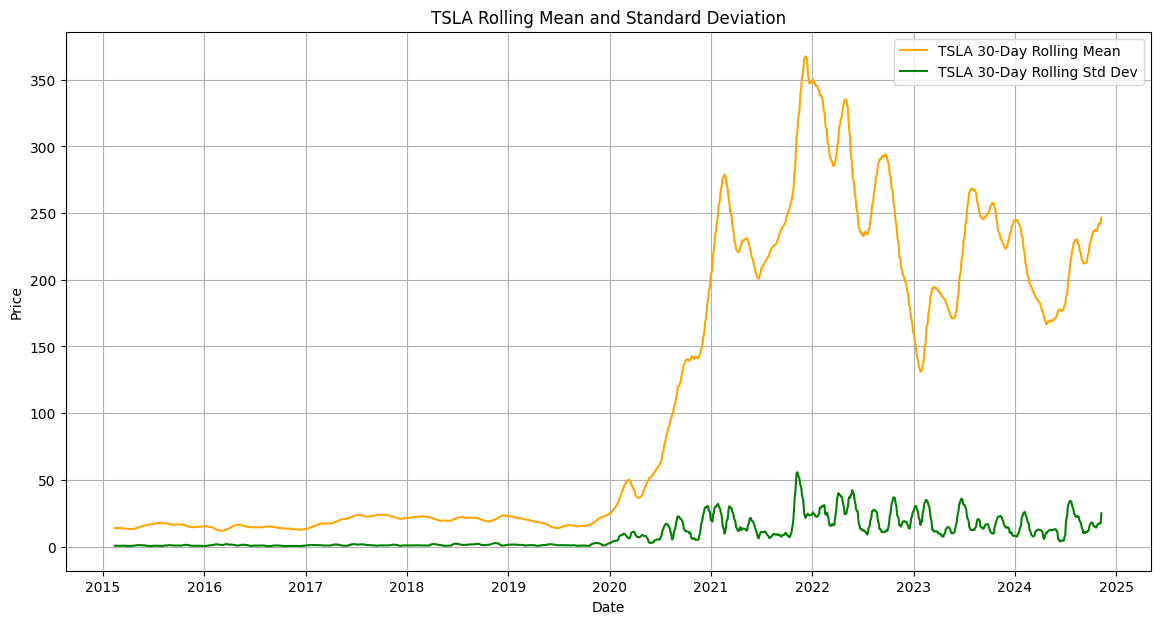

In [99]:
tsla_rolling_mean = combined_data['TSLA'].rolling(window=30).mean()
tsla_rolling_std = combined_data['TSLA'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(tsla_rolling_mean, label='TSLA 30-Day Rolling Mean', color='orange')
plt.plot(tsla_rolling_std, label='TSLA 30-Day Rolling Std Dev', color='green')
plt.title('TSLA Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Calculate the Sharp Ratio and VaR for TSLA

In [100]:
sharpe_ratio = daily_returns['TSLA'].mean() / daily_returns['TSLA'].std() * np.sqrt(252)
VaR_95 = daily_returns['TSLA'].quantile(0.05)

print("\nKey Insights:")
print(f"Sharpe Ratio for TSLA: {sharpe_ratio:.2f}")
print(f"95% VaR for TSLA: {VaR_95:.2f}%")

# Sharpe Ratio and VaR calculations for BND and SPY
for ticker in ['BND', 'SPY']:
    sharpe_ratio = daily_returns[ticker].mean() / daily_returns[ticker].std() * np.sqrt(252)
    VaR_95 = daily_returns[ticker].quantile(0.05)
    print(f"Sharpe Ratio for {ticker}: {sharpe_ratio:.2f}")
    print(f"95% VaR for {ticker}: {VaR_95:.2f}%")


Key Insights:
Sharpe Ratio for TSLA: 0.83
95% VaR for TSLA: -5.12%
Sharpe Ratio for BND: 0.29
95% VaR for BND: -0.48%
Sharpe Ratio for SPY: 0.80
95% VaR for SPY: -1.68%


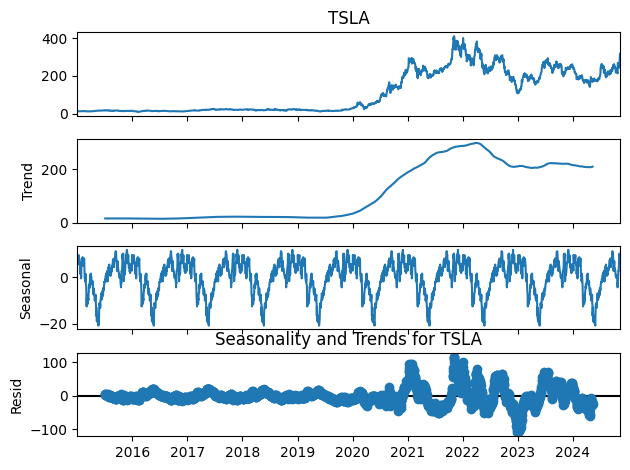

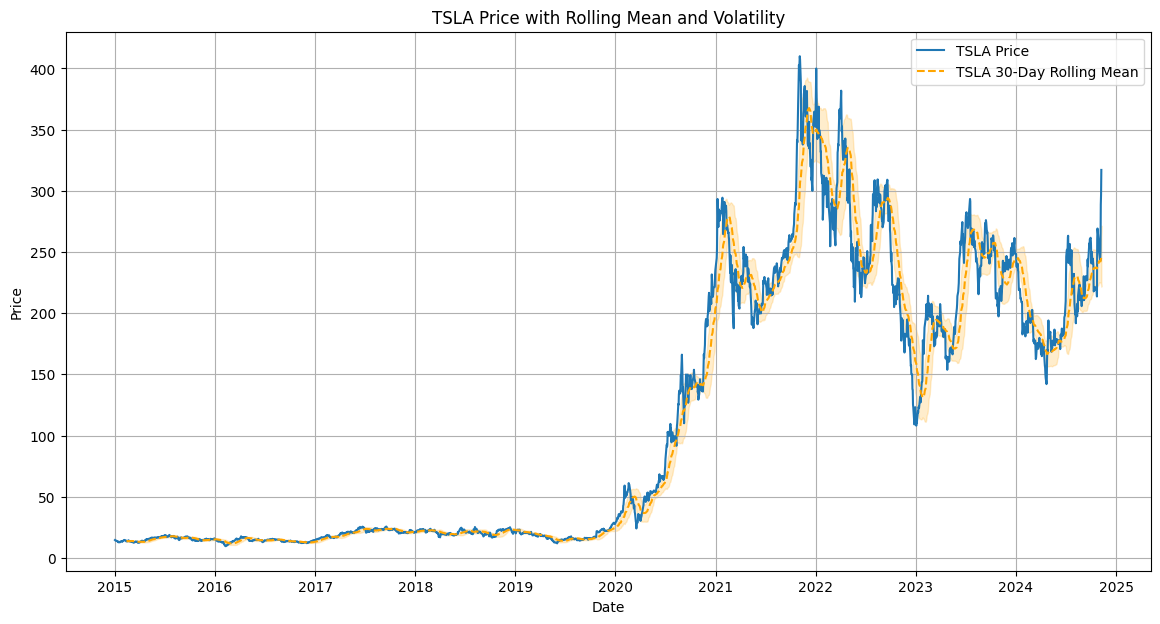


Sharpe Ratio for TSLA: 0.8324490591121084
95% VaR for TSLA: -5.123739222112824


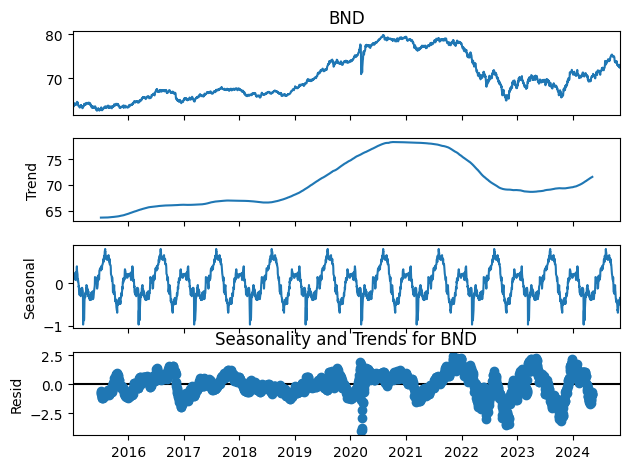

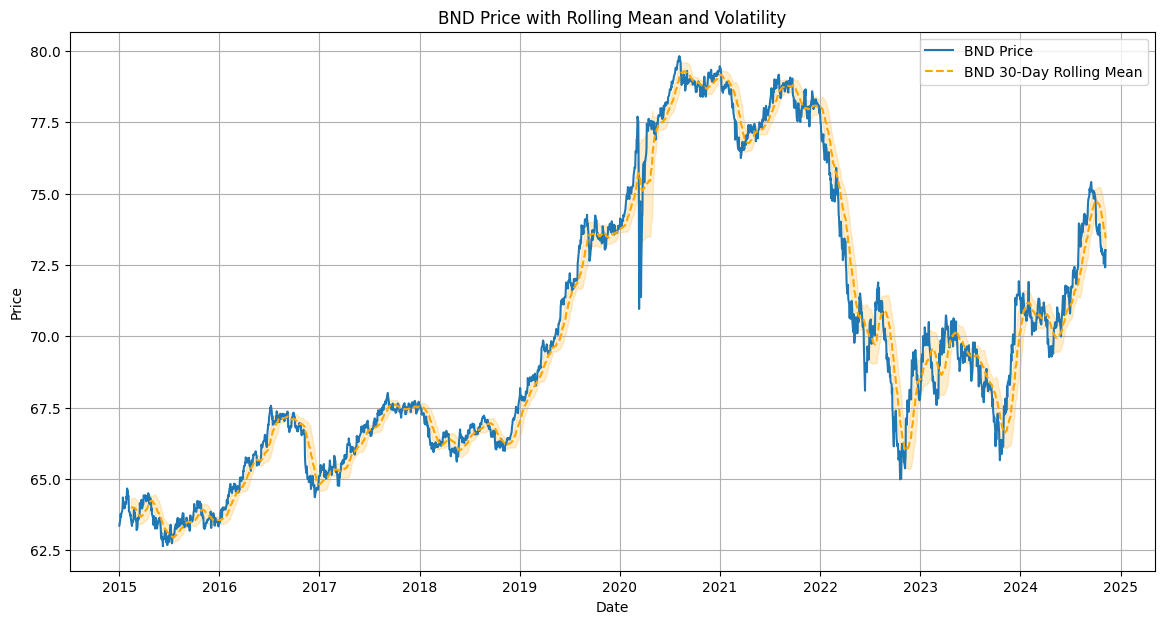


Sharpe Ratio for BND: 0.29173704956287017
95% VaR for BND: -0.4798214762899994


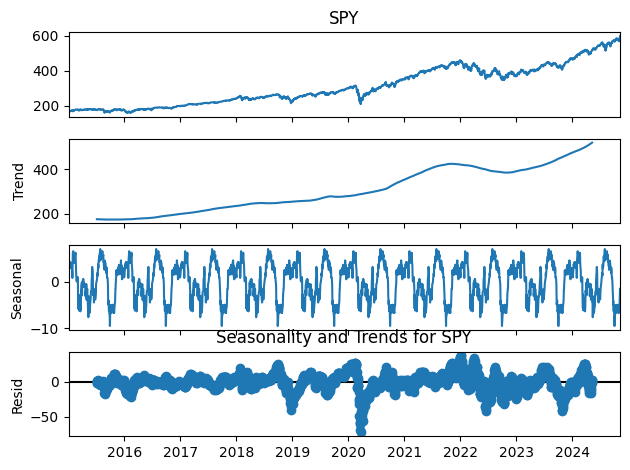

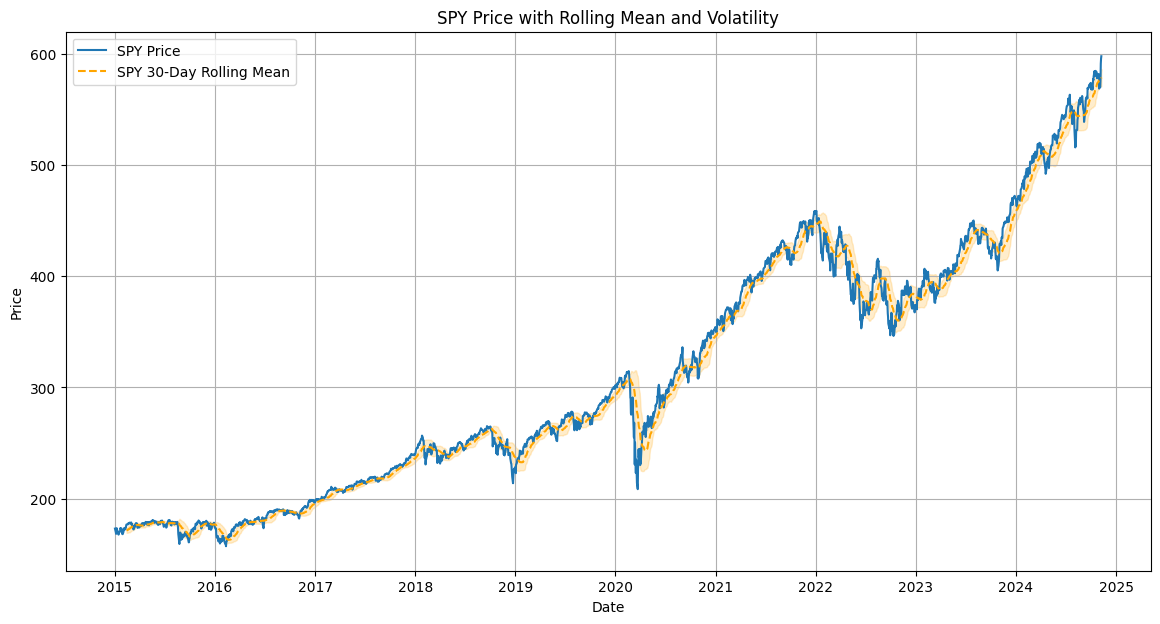


Sharpe Ratio for SPY: 0.8008095004401395
95% VaR for SPY: -1.6779871495602476


In [101]:
def analyze_asset(asset):
    # Decompose Time Series
    decomposition = seasonal_decompose(combined_data[asset], model='additive', period=252)
    decomposition.plot()
    plt.title(f'Seasonality and Trends for {asset}')
    plt.show()

    # Analyze Volatility
    rolling_mean = combined_data[asset].rolling(window=30).mean()
    rolling_std = combined_data[asset].rolling(window=30).std()

    plt.figure(figsize=(14, 7))
    plt.plot(combined_data[asset], label=f'{asset} Price')
    plt.plot(rolling_mean, label=f'{asset} 30-Day Rolling Mean', linestyle='--', color='orange')
    plt.fill_between(rolling_std.index, 
                     rolling_mean - rolling_std, 
                     rolling_mean + rolling_std, 
                     alpha=0.2, color='orange')
    plt.title(f'{asset} Price with Rolling Mean and Volatility')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate Sharpe Ratio and Value at Risk (VaR)
    sharpe_ratio = daily_returns[asset].mean() / daily_returns[asset].std() * (252 ** 0.5)
    VaR_95 = daily_returns[asset].quantile(0.05)

    print(f"\nSharpe Ratio for {asset}:", sharpe_ratio)
    print(f"95% VaR for {asset}:", VaR_95)

# Analyze each asset
for ticker in tickers:
    analyze_asset(ticker)